# TODO:
- add dataloader for batch processing
- replace streaming video with bach prediction
- Use dataloader and reader from torch unless hf has its own

### DETR (DEtection TRansformers) Model:
   - DETR is a state-of-the-art object detection model that utilizes transformer architecture, originally proposed by Facebook AI.
   - Unlike traditional object detection models that rely on anchor boxes and proposal generation, DETR directly predicts object bounding boxes and class labels in a single pass using transformer-based encoder-decoder architecture.
   - It has been shown to achieve competitive performance on object detection benchmarks with fewer heuristics and hyperparameters.


### DETR:
   - DETR offers a novel approach to object detection using transformer architecture, which allows for end-to-end training and inference.
   - It is suitable for applications where precise localization and accurate detection of objects are important, such as autonomous driving and medical imaging.


# DETR Architecture 

## DETR Architecture:
- **Encoder-Decoder Architecture**: DETR utilizes a transformer-based encoder-decoder architecture.
- **Encoder**: The encoder processes the input image using a series of transformer encoder layers to extract high-level features.
- **Decoder**: The decoder generates object queries and attends to the encoded image features to predict object bounding boxes and class labels.
- **Positional Encoding**: DETR uses positional encoding to provide spatial information to the transformer model.
- **Learnable Class Embeddings**: Instead of using predefined anchor boxes, DETR predicts object classes using learnable class embeddings.
- **Direct Prediction**: DETR directly predicts object bounding boxes and class labels in a single pass without the need for anchor box generation or non-maximum suppression.


In [108]:
from glob import glob
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch
from model import InferDataset
from torch.utils.data import DataLoader

from transformers import pipeline
from PIL import ImageDraw




### Directory Setup:
- The script initializes the `img_dir` variable using the `glob` function to fetch all JPEG images from the `./imgs/` directory.
- The content of `img_dir` is printed to verify the paths of the image files.

In [103]:
img_dir = glob("./imgs/*jpg")
print(img_dir)

['./imgs/000000000139.jpg', './imgs/000000000885.jpg', './imgs/000000000285.jpg', './imgs/000000000785.jpg', './imgs/000000002431.jpg']


### Image Transformation:
- The script defines a series of transformations using `torchvision.transforms.Compose`, resizing each image to dimensions of 512x512 pixels.
- We do this because all images should be the same size

In [104]:
transform=torchvision.transforms.Compose([
            transforms.Resize((512, 512))])

### Dataset Preparation:
- An `InferDataset` instance is created, specifying the `img_dir` and transformation.
- A `DataLoader` named `infer_loader` is created to load images in batches for inference. Parameters include batch size, shuffling, number of workers, and pin memory.
- Loading the data through a dataloader gives us several benefits like multiprocessing when loading data and such. It has been shown that using a dataloader to do inference in batches increases speed, rather than doing a list of images etc.

In [ ]:
infer_data = InferDataset(img_dir=img_dir, transform=transform)
infer_loader = DataLoader(infer_data,
                          batch_size=64,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)


### Retrieve Image Batch:
- The script retrieves a batch of images from the `infer_loader`, assigning the first image to the variable `img`.

### Display Image:
- The script displays the first image from the batch using `plt.imshow`.

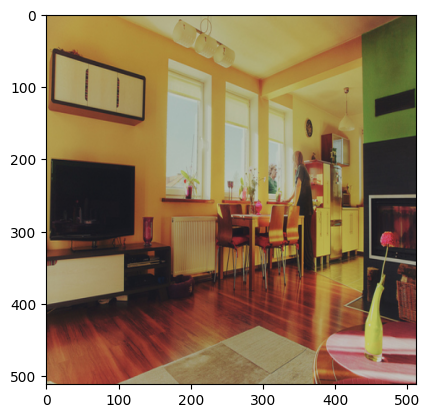

In [105]:
imgs = next(iter(infer_loader))
img = imgs[0].squeeze()

plt.imshow(img.permute(1, 2, 0))
plt.show()

### Load Object Detection Model:
- The DETR object detection pipeline model is loaded using the `pipeline` function from the `transformers` library. The model checkpoint is specified as `facebook/detr-resnet-50`.

In [106]:
checkpoint = "facebook/detr-resnet-50"

pipe = pipeline(model=checkpoint, task="object-detection")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Perform Object Detection:
- Object detection is performed on the image batch using the loaded pipeline model. Predictions are stored in the `predictions` variable.


In [107]:
with torch.no_grad():
    T = transforms.ToPILImage()
    pil_img = T(img)
    predictions = pipe(pil_img)

### Draw Bounding Boxes and Labels:
- Bounding boxes and labels are drawn on the image using the `PIL` library and `ImageDraw` class. Each prediction in `predictions` is iterated over, and the bounding box coordinates, label, and confidence score are extracted and displayed on the image.

In [109]:
draw = ImageDraw.Draw(pil_img)
for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")


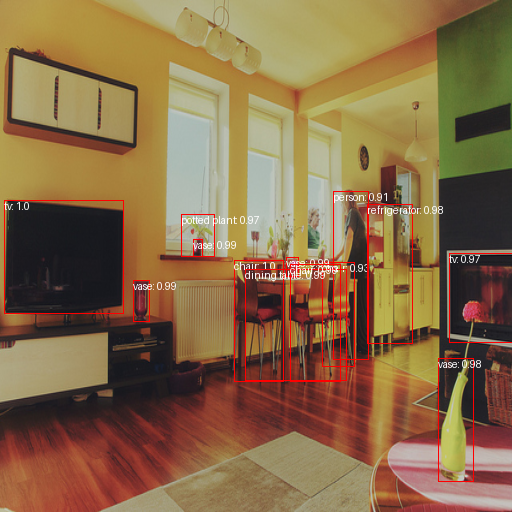

In [110]:
display(pil_img)

## As a python class

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


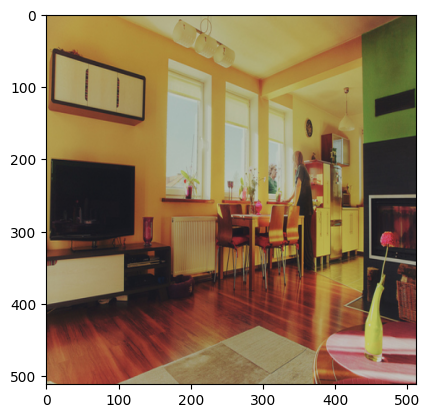

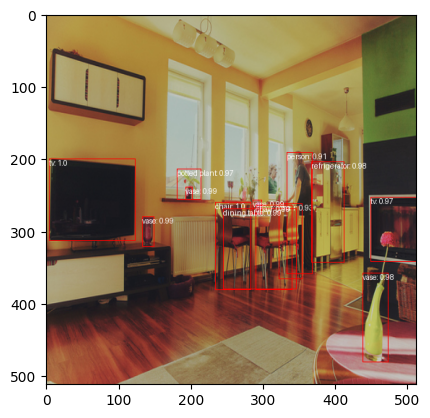

In [113]:
import glob
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import ImageDraw
from transformers import pipeline
from model import InferDataset

class ObjectDetectionPipeline:
    def __init__(self, img_dir: str, batch_size: int = 64):
        """
        Initializes the object detection pipeline.

        Args:
            img_dir (str): Directory containing images.
            batch_size (int): Batch size for DataLoader (default is 64).
        """
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.Resize((512, 512))
        ])
        self.infer_data = InferDataset(img_dir=self.img_dir, transform=self.transform)
        self.infer_loader = DataLoader(
            self.infer_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        self.pipe = pipeline(model="facebook/detr-resnet-50", task="object-detection")

    def infer_and_display(self):
        """
        Performs object detection on images from the directory and displays the results.
        """
        imgs = next(iter(self.infer_loader))
        img = imgs[0].squeeze()
        plt.imshow(img.permute(1, 2, 0))
        plt.show()

        with torch.no_grad():
            T = transforms.ToPILImage()
            pil_img = T(img)
            predictions = self.pipe(pil_img)

        draw = ImageDraw.Draw(pil_img)
        for prediction in predictions:
            box = prediction["box"]
            label = prediction["label"]
            score = prediction["score"]

            xmin, ymin, xmax, ymax = box.values()
            draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
            draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill="white")

        plt.imshow(pil_img)
        plt.show()

# Usage example:
img_dir = glob.glob("./imgs/*jpg")
obj_detection = ObjectDetectionPipeline(img_dir=img_dir)
obj_detection.infer_and_display()
